# XGBoost

In this tutorial we learn how to process data, train an XGBoost model and validate any model.

# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path

In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [3]:
# Load data - set index column, decimal point, separator
data_file = Path("../Data/data_devsample.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'SK_ID_CURR')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-02 17:44:12


In [4]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_AMTCR_0M_INFM,MAX_AMTCR_0M_INFM,MEAN_AMTCR_0M_INFM,MEDIAN_AMTCR_0M_INFM,STD_AMTCR_0M_INFM,MIN_AMTCR_0M_6M,MAX_AMTCR_0M_6M,MEAN_AMTCR_0M_6M,MEDIAN_AMTCR_0M_6M,STD_AMTCR_0M_6M,MIN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,STD_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MAX_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,STD_AMTCR_0M_6M_TYPE_EQ_CLOSED,MIN_DPD_0M_INFM,MAX_DPD_0M_INFM,MEAN_DPD_0M_INFM,MEDIAN_DPD_0M_INFM,STD_DPD_0M_INFM,MIN_DPD_0M_6M,MAX_DPD_0M_6M,MEAN_DPD_0M_6M,MEDIAN_DPD_0M_6M,STD_DPD_0M_6M,MIN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MAX_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,STD_DPD_0M_INFM_TYPE_EQ_ACTIVE,MIN_DPD_0M_6M_TYPE_EQ_ACTIVE,MAX_DPD_0M_6M_TYPE_EQ_ACTIVE,MEAN_DPD_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_6M_TYPE_EQ_ACTIVE,STD_DPD_0M_6M_TYPE_EQ_ACTIVE,MIN_DPD_0M_INFM_TYPE_EQ_CLOSED,MAX_DPD_0M_INFM_TYPE_EQ_CLOSED,MEAN_DPD_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_INFM_TYPE_EQ_CLOSED,STD_DPD_0M_INFM_TYPE_EQ_CLOSED,MIN_DPD_0M_6M_TYPE_EQ_CLOSED,MAX_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_DPD_0M_6M_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED,STD_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M,MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE,MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED,MEAN_AMTCR_OVERDUE_0M_IN

In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   80 000
Number of unique indexes:   80 000
Number of columns:   196


# Metadata Definitions

In [6]:
# check values in column TARGET
data.TARGET.value_counts(dropna=False)

TARGET
0.0    73584
1.0     6416
Name: count, dtype: int64

In [7]:
#name of the target column
col_target = "TARGET"
#name of the time column
col_time = "TIME"

#name of the month column
col_month = "MONTH"

In [8]:
# define list of predictors
cols_pred = list(data.columns[1:-4])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
CNT_CHILDREN                                                                       float64
AMT_INCOME_TOTAL                                                                   float64
AMT_CREDIT                                                                         float64
AMT_ANNUITY                                                                        float64
AMT_GOODS_PRICE                                                                    float64
REGION_POPULATION_RELATIVE                                                         float64
DAYS_BIRTH                                                                         float64
DAYS_EMPLOYED                                                                        int64
DAYS_REGISTRATION                                                                  float64
DAYS_ID_PUBLISH                                                                      int64
OWN_CAR_AGE                                   

In [9]:
# convert col_time to date
if data[col_time].dtype == 'O':
    data[col_time] = data[col_time].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

# Data Split

In [ ]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [11]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201701, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201911, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201701) & (data[col_month] < 201911)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12, stratify = (data[intime_mask][[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

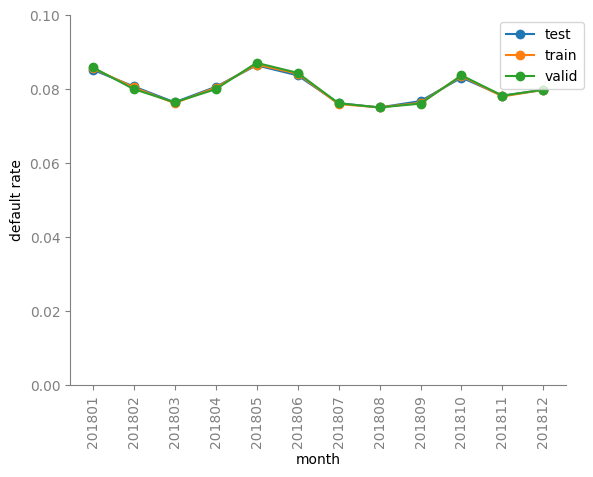

In [12]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

## Define Sample Masks

In [13]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
oot_mask = (data['sample'] == 'oot')  
hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Replace infinity

In [14]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

Column MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE includes infinity values.


In [15]:
# replace infinity values
for col in cols_with_inf:
    data[col] = data[col].replace(np.inf, 9999999)

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot DR_{category} + \alpha \cdot DR}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $DR_{category}$ default rate in this category and $DR$ is total default rate.

In [16]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [17]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
cols_pred

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXP

# XGBoost model
- XGBoost model is provided in package `xgboost`
- https://xgboost.readthedocs.io/en/stable/

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [41]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 4,
    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'gamma': 10
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.70168	test-auc:0.68210	valid-auc:0.69549
[1]	train-auc:0.71849	test-auc:0.69109	valid-auc:0.71184
[2]	train-auc:0.72640	test-auc:0.69856	valid-auc:0.71976
[3]	train-auc:0.73423	test-auc:0.70717	valid-auc:0.72644
[4]	train-auc:0.73808	test-auc:0.71143	valid-auc:0.72807
[5]	train-auc:0.74166	test-auc:0.71543	valid-auc:0.73059
[6]	train-auc:0.74777	test-auc:0.71716	valid-auc:0.73315
[7]	train-auc:0.75144	test-auc:0.71871	valid-auc:0.73584
[8]	train-auc:0.75503	test-auc:0.72198	valid-auc:0.73918
[9]	train-auc:0.75710	test-auc:0.72353	valid-auc:0.74010
[10]	train-auc:0.75971	test-auc:0.72565	valid-auc:0.74013
[11]	train-auc:0.76394	test-auc:0.72819	valid-auc:0.74320
[12]	train-auc:0.76706	test-auc:0.72914	valid-auc:0.74448
[13]	train-auc:0.76931	test-auc:0.72954	valid-auc:0.74514
[14]	train-auc:0.77148	test-auc:0.72955	valid-auc:0.74676
[15]	train-auc:0.77308	test-auc:0.72972	valid-auc:0.74742
[16]	train-auc:0.77389	test-auc:0.72971	valid-auc:0.74739
[17]	train-auc:0.77459	t

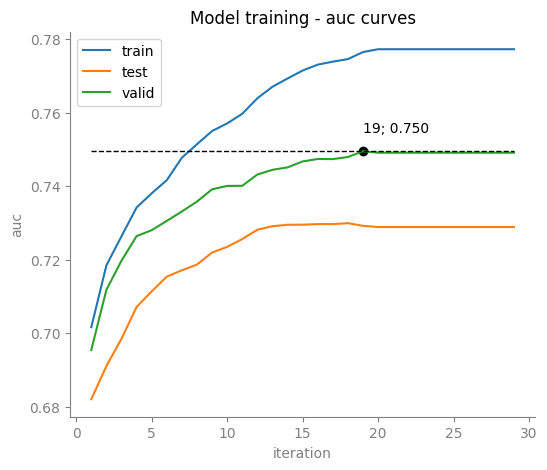

In [42]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

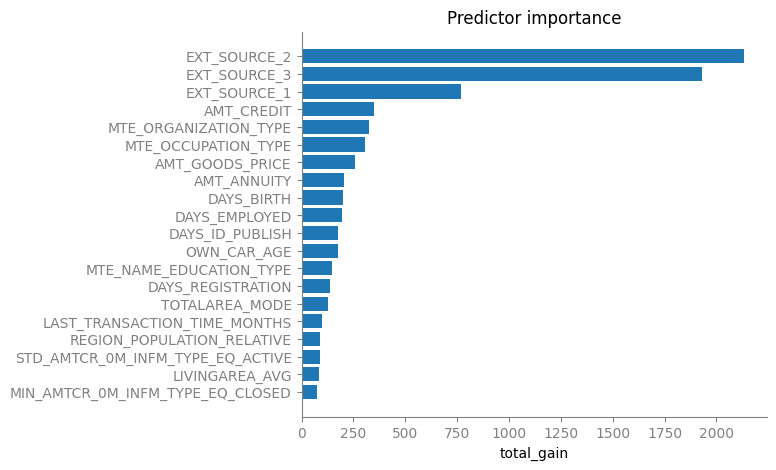

In [21]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 20
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:20])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:20])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

<span style="color:red">**TO DO:** change the hyperparameters and observe performance and training</span>

## XGBoost in sklearn

In [22]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=10,
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.73120	validation_1-auc:0.69253	validation_2-auc:0.70443
[1]	validation_0-auc:0.75211	validation_1-auc:0.70149	validation_2-auc:0.71902
[2]	validation_0-auc:0.76328	validation_1-auc:0.70445	validation_2-auc:0.72631
[3]	validation_0-auc:0.77283	validation_1-auc:0.70780	validation_2-auc:0.73126
[4]	validation_0-auc:0.78162	validation_1-auc:0.71231	validation_2-auc:0.73557
[5]	validation_0-auc:0.79075	validation_1-auc:0.71275	validation_2-auc:0.73370
[6]	validation_0-auc:0.80037	validation_1-auc:0.71481	validation_2-auc:0.73449
[7]	validation_0-auc:0.80586	validation_1-auc:0.71796	validation_2-auc:0.73700
[8]	validation_0-auc:0.81279	validation_1-auc:0.71922	validation_2-auc:0.73812
[9]	validation_0-auc:0.81800	validation_1-auc:0.71972	validation_2-auc:0.73865
[10]	validation_0-auc:0.82195	validation_1-auc:0.72024	validation_2-auc:0.74123
[11]	validation_0-auc:0.82779	validation_1-auc:0.72175	validation_2-auc:0.74327
[12]	validation_0-auc:0.83117	validation_1-auc:0.7

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [23]:
params={
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1.0
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

[0]	train-auc:0.62299	test-auc:0.61155
[1]	train-auc:0.71242	test-auc:0.69761
[2]	train-auc:0.72132	test-auc:0.70633
[3]	train-auc:0.72428	test-auc:0.70864
[4]	train-auc:0.72612	test-auc:0.70988
[5]	train-auc:0.72644	test-auc:0.71149
[6]	train-auc:0.73185	test-auc:0.71443
[7]	train-auc:0.73382	test-auc:0.71749
[8]	train-auc:0.73393	test-auc:0.71780
[9]	train-auc:0.73471	test-auc:0.71713
[10]	train-auc:0.73467	test-auc:0.71709
[11]	train-auc:0.73583	test-auc:0.71834
[12]	train-auc:0.73582	test-auc:0.71887
[13]	train-auc:0.73647	test-auc:0.71942
[14]	train-auc:0.73841	test-auc:0.72072
[15]	train-auc:0.74109	test-auc:0.72250
[16]	train-auc:0.74224	test-auc:0.72345
[17]	train-auc:0.74266	test-auc:0.72364
[18]	train-auc:0.74303	test-auc:0.72356
[19]	train-auc:0.74402	test-auc:0.72428
[20]	train-auc:0.74476	test-auc:0.72430
[21]	train-auc:0.74562	test-auc:0.72500
[22]	train-auc:0.74721	test-auc:0.72622
[23]	train-auc:0.74808	test-auc:0.72696
[24]	train-auc:0.74905	test-auc:0.72699
[25]	train

In [24]:
# Performance during cross validation
cv_res

[(0.599903713278773, 0.4828592420069635, 107),
 (0.5899084863536961, 0.490873519140288, 113)]

In [25]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

Cross validation score performance: 0.4872


In [26]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

[0]	train-auc:0.62183
[1]	train-auc:0.68658
[2]	train-auc:0.71522
[3]	train-auc:0.71690
[4]	train-auc:0.72012
[5]	train-auc:0.72280
[6]	train-auc:0.72185
[7]	train-auc:0.72281
[8]	train-auc:0.72515
[9]	train-auc:0.72510
[10]	train-auc:0.72455
[11]	train-auc:0.72594
[12]	train-auc:0.72600
[13]	train-auc:0.72693
[14]	train-auc:0.72842
[15]	train-auc:0.72936
[16]	train-auc:0.73070
[17]	train-auc:0.73198
[18]	train-auc:0.73311
[19]	train-auc:0.73402
[20]	train-auc:0.73591
[21]	train-auc:0.73742
[22]	train-auc:0.73787
[23]	train-auc:0.73813
[24]	train-auc:0.73878
[25]	train-auc:0.73886
[26]	train-auc:0.73919
[27]	train-auc:0.74002
[28]	train-auc:0.74074
[29]	train-auc:0.74211
[30]	train-auc:0.74276
[31]	train-auc:0.74318
[32]	train-auc:0.74493
[33]	train-auc:0.74558
[34]	train-auc:0.74592
[35]	train-auc:0.74682
[36]	train-auc:0.74765
[37]	train-auc:0.74841
[38]	train-auc:0.74968
[39]	train-auc:0.75038
[40]	train-auc:0.75117
[41]	train-auc:0.75129
[42]	train-auc:0.75184
[43]	train-auc:0.7523

In [27]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

0.557183625180905


### Final model using splitted data

In [28]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['logloss', 'auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 300,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-logloss:0.30047	train-auc:0.60952	test-logloss:0.30079	test-auc:0.58980	valid-logloss:0.30072	valid-auc:0.60881
[1]	train-logloss:0.29456	train-auc:0.70777	test-logloss:0.29505	test-auc:0.68801	valid-logloss:0.29495	valid-auc:0.70544
[2]	train-logloss:0.28994	train-auc:0.71626	test-logloss:0.29040	test-auc:0.70062	valid-logloss:0.29047	valid-auc:0.71153
[3]	train-logloss:0.28530	train-auc:0.71932	test-logloss:0.28599	test-auc:0.70158	valid-logloss:0.28585	valid-auc:0.71635
[4]	train-logloss:0.28135	train-auc:0.71917	test-logloss:0.28218	test-auc:0.70309	valid-logloss:0.28189	valid-auc:0.71644
[5]	train-logloss:0.27793	train-auc:0.72168	test-logloss:0.27900	test-auc:0.70364	valid-logloss:0.27843	valid-auc:0.72039
[6]	train-logloss:0.27485	train-auc:0.72286	test-logloss:0.27620	test-auc:0.70285	valid-logloss:0.27543	valid-auc:0.72159
[7]	train-logloss:0.27229	train-auc:0.72571	test-logloss:0.27399	test-auc:0.70436	valid-logloss:0.27293	valid-auc:0.72394
[8]	train-logloss:0.2698

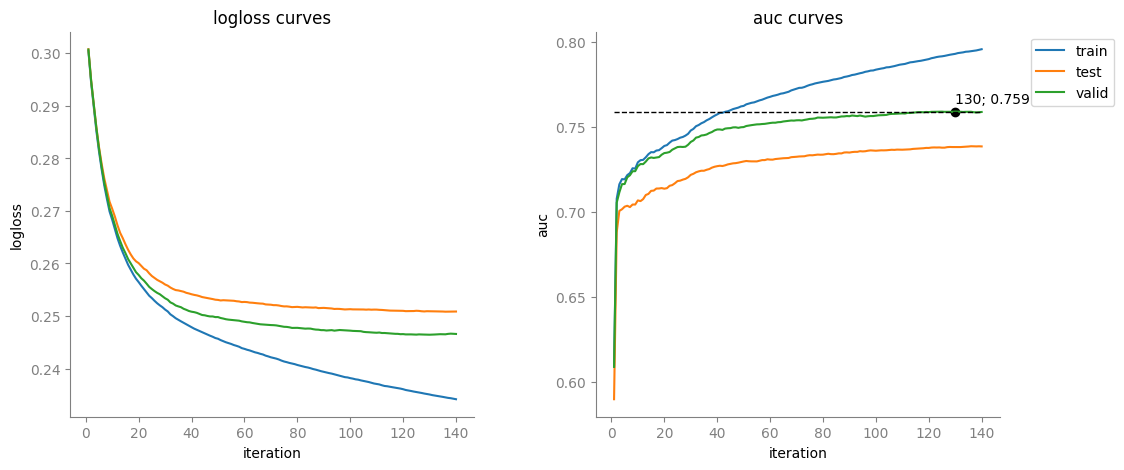

In [29]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

#### Applying monotone constraints

<span style="color:red">**TO DO:** Define function for marginal dependence.</span>

Function should have following input parameters:
- data ... pd.DataFrame with data to be used for marginal dependence calculation, TARGET is included in this dataframe
- predictor ... name of the predictor to be analysed
- bins ... number of bins to split the predictor into
- col_target ... the TARGET column to compute default date


It should output a graph with the default rate for each bin, for example
marginal_dependence(data[train_mask], 'EXT_SOURCE_1', 10, col_target) should give something like

<img src="marginal_dependence.png" width=400px style="float: left"/>




In [43]:
 def marginal_dependence(data, predictor, bins, col_target):
     dt = data.copy()
     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
     dt.groupby(predictor + 'bin').agg(
         def_rt=(col_target, np.mean),
     ).plot(figsize=(9, 6))

In [44]:
positive_monotone_constraint = [
]

negative_monotone_constraint = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

constr = []
for col in cols_pred:
    if col in positive_monotone_constraint:
        constr.append('1')
    elif col in negative_monotone_constraint:
        constr.append('-1')
    else:
        constr.append('0')

constr = '(' + ','.join(constr) + ')'
constr

'(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)'

In [32]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-auc:0.60428	test-auc:0.58660	valid-auc:0.60098
[1]	train-auc:0.70409	test-auc:0.69029	valid-auc:0.70429
[2]	train-auc:0.70978	test-auc:0.69977	valid-auc:0.70995
[3]	train-auc:0.72083	test-auc:0.70839	valid-auc:0.72054
[4]	train-auc:0.72055	test-auc:0.70766	valid-auc:0.71945
[5]	train-auc:0.72007	test-auc:0.70742	valid-auc:0.71915
[6]	train-auc:0.72142	test-auc:0.70605	valid-auc:0.71965
[7]	train-auc:0.72419	test-auc:0.70581	valid-auc:0.72280
[8]	train-auc:0.72333	test-auc:0.70537	valid-auc:0.72237
[9]	train-auc:0.72791	test-auc:0.70840	valid-auc:0.72671
[10]	train-auc:0.72850	test-auc:0.70745	valid-auc:0.72717
[11]	train-auc:0.72822	test-auc:0.70821	valid-auc:0.72672
[12]	train-auc:0.72966	test-auc:0.71060	valid-auc:0.72905
[13]	train-auc:0.73092	test-auc:0.71073	valid-auc:0.73082
[14]	train-auc:0.73207	test-auc:0.71312	valid-auc:0.73106
[15]	train-auc:0.73208	test-auc:0.71345	valid-auc:0.73052
[16]	train-auc:0.73268	test-auc:0.71460	valid-auc:0.73075
[17]	train-auc:0.73295	t

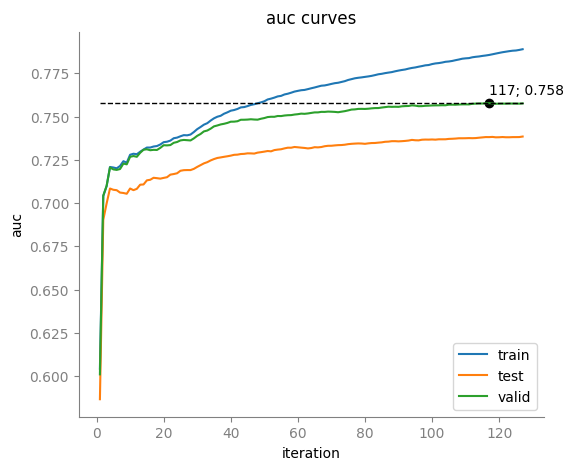

In [33]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [45]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

## Plot individual trees

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

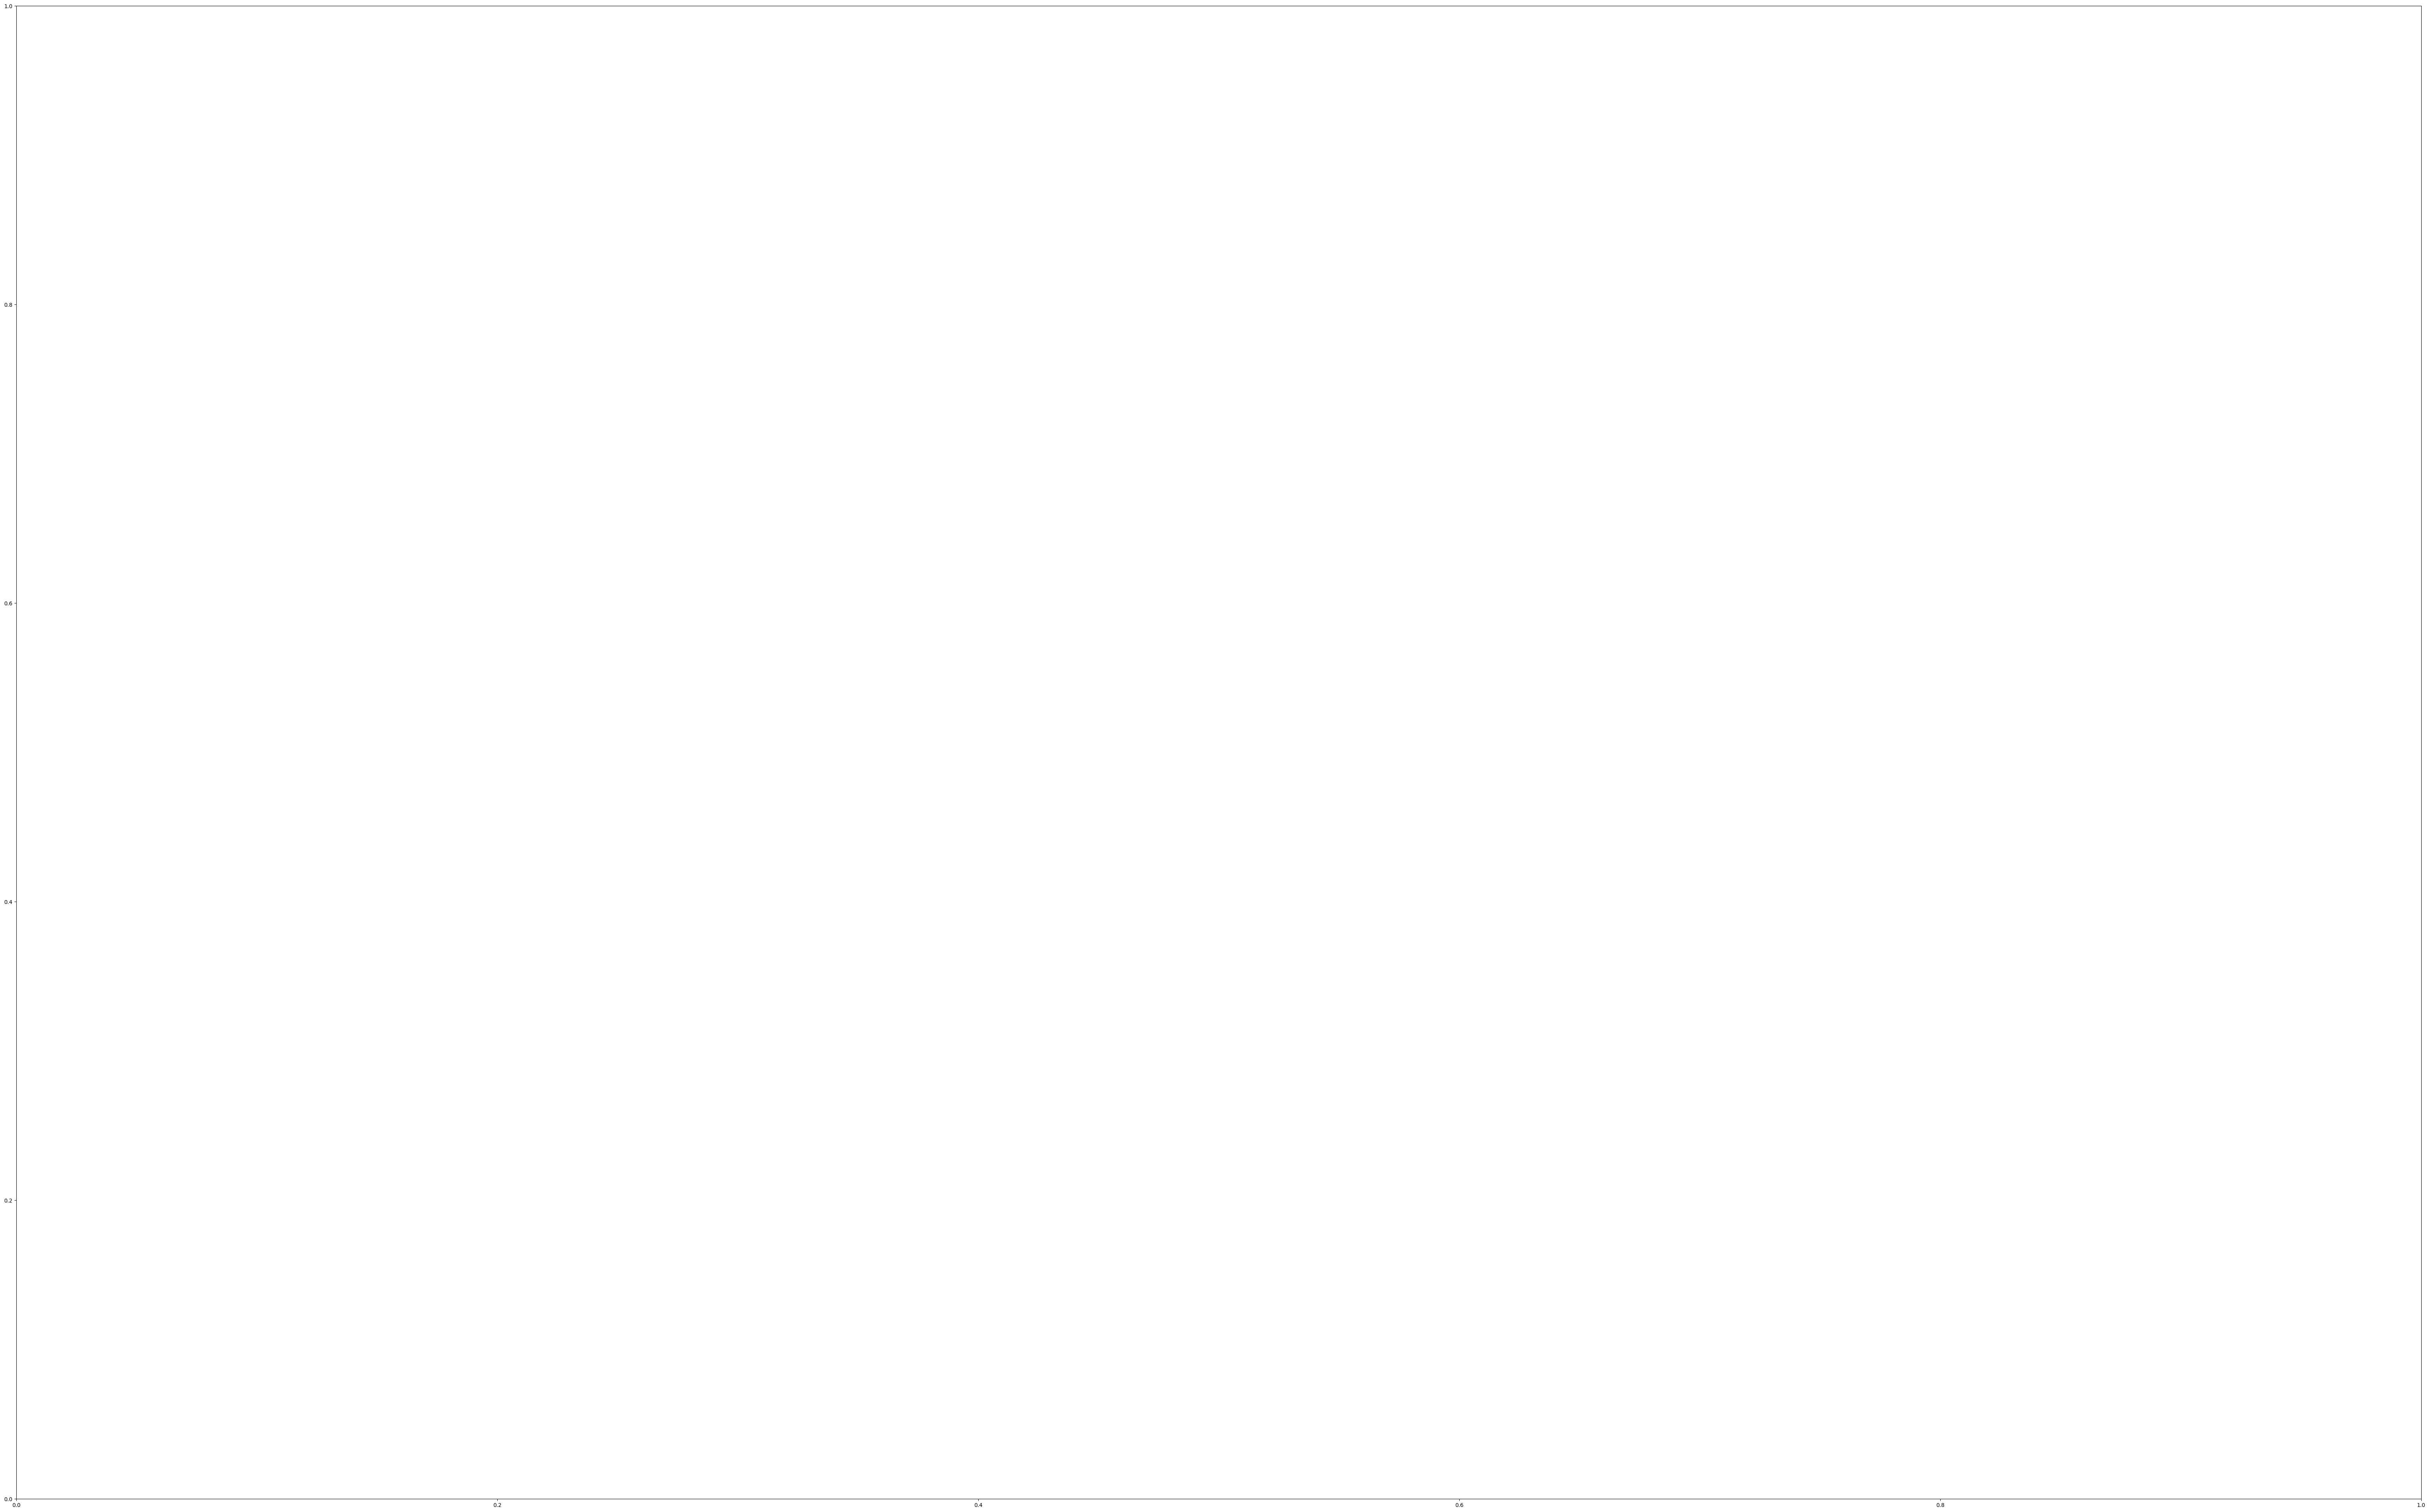

In [46]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [47]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

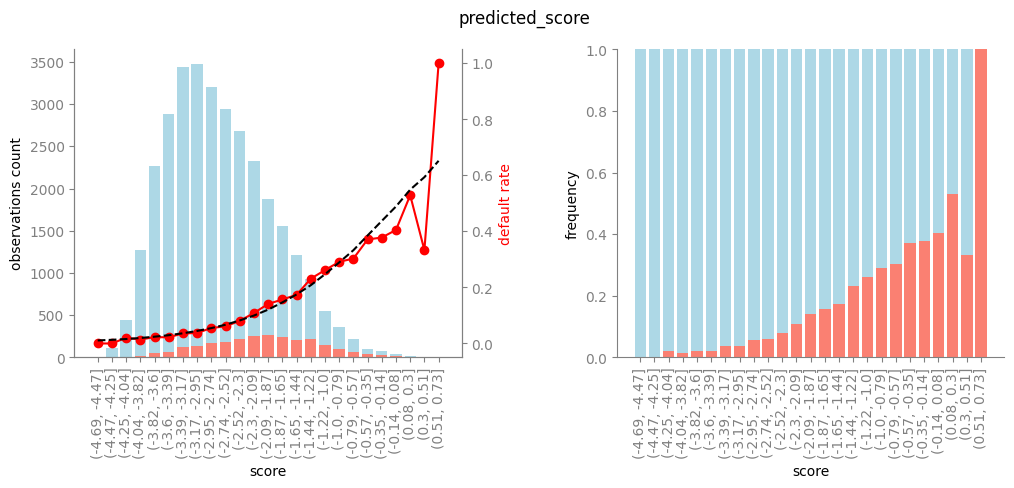

In [48]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [49]:
from sklearn.inspection import permutation_importance

In [50]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

In [51]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

AMT_CREDIT    0.0007 +/- 0.0002
AMT_GOODS_PRICE    0.0006 +/- 0.0002
AMT_REQ_CREDIT_BUREAU_QRT    0.0001 +/- 0.0000
NONLIVINGAREA_AVG    0.0001 +/- 0.0000
YEARS_BEGINEXPLUATATION_MEDI    0.0001 +/- 0.0000


In [ ]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [ ]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

## Marginal contribution

In [ ]:
def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

In [ ]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [ ]:
marginal_contribution

In [ ]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## PDP plots
- PDP = Partial Dependence Plot

In [ ]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

In [ ]:
lst_f = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
# cols_pred
sampled_data = data.sample(frac=0.1, random_state=22)
for f in lst_f:
    f_id = cols_pred.index(f)
    feature_ids = range(len(cols_pred))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][cols_pred].values,
        sampled_data[mask][col_target].values,
        feature_names = cols_pred,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

## ICE plots
- ICE = Individual Conditional Expectation

In [ ]:
def ice_data(bst, dt, predictor, n_points=20):
    X = dt.copy()
    grid = np.linspace(
        dt[predictor].quantile(0.01),
        dt[predictor].quantile(0.99),
        n_points
    )
    
    y_pred = np.zeros((len(dt), len(grid)))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X[predictor] = val
            data = xgb.DMatrix(X, feature_names = X.columns.to_list())

            y_pred[:,i] = bst.predict(data)
    return grid, y_pred

In [ ]:
n_plots = 100
cols_to_plot = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

sampled_data = data.sample(n=10000, random_state=22)

for pred in cols_to_plot:
    x, ice_data_plot = ice_data(booster, sampled_data[cols_pred], pred)

    idx = np.random.randint(len(x), size=n_plots)
    plt.plot(x, np.transpose(ice_data_plot[idx,:]), lw = 0.5, color = 'lightblue')
    plt.plot(x, np.average(ice_data_plot[idx,:], axis = 0), lw = 2, ls = '--', color = 'blue', label = 'Partial dependance curve')
    plt.title(pred)
    plt.ylabel('Predicted value')
    plt.xlabel('Values')
    plt.legend(loc='best')
    plt.show()

## SHAP
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SHAP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

In [ ]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

In [ ]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [ ]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

In [ ]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

In [ ]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')

Better example of high interaction: https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/

In [ ]:
# def marginal_dependence(data, predictor, bins, col_target):
#     dt = data.copy()
#     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
#     dt.groupby(predictor + 'bin').agg(
#         def_rt=(col_target, np.mean),
#     ).plot(figsize=(9, 6))